# Tutorial 5: Integrated Neurosymbolic System for Single-to-Multiview 3D Understanding

In this final tutorial, we'll integrate all the components we've created in the previous tutorials to build a complete neurosymbolic system for understanding 3D objects from single 2D images.

## Setup and Dependencies

In [ ]:
# Install necessary packages
!pip install transformers torch pillow matplotlib networkx rdflib
!pip install timm  # For vision models

## Import Libraries

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import AutoImageProcessor, AutoModel
from transformers import DPTForDepthEstimation, DPTImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
import cv2
import json
import networkx as nx
import rdflib
from rdflib import Graph, Literal, RDF, URIRef, Namespace, BNode
from rdflib.namespace import RDFS, XSD

/Users/brandonhager/Documents/Neurosymbolic-LLM-tutorials/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load a Sample Image

Let's start by loading a sample image of a 3D object:

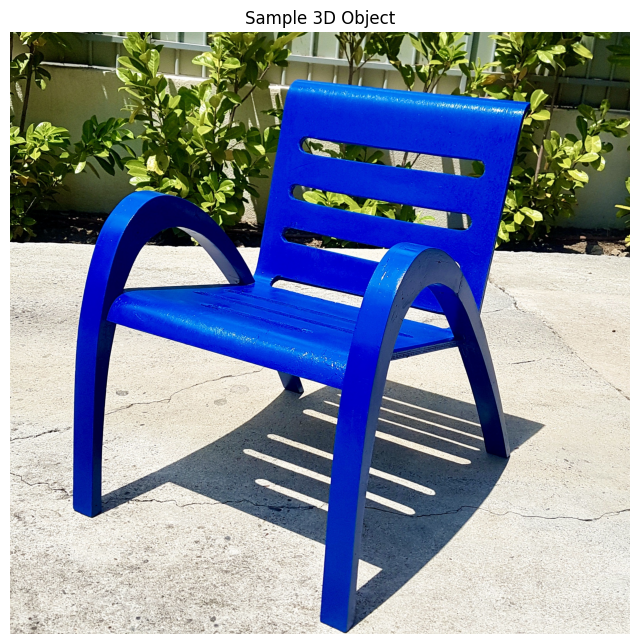

In [3]:
# Function to load an image from URL
def load_image_from_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
        'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.google.com/'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()  # Raise an exception for bad status codes
        
        # Check if the response is actually an image
        if 'image' not in response.headers.get('content-type', '').lower():
            raise ValueError('URL does not point to an image')
            
        img = Image.open(BytesIO(response.content))
        return img
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Load a sample image of a chair
url = "https://upload.wikimedia.org/wikipedia/commons/8/86/Fauteuil_Riviera_Chaise_Bleue_Neptune_SBR.jpg"
image = load_image_from_url(url)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title("Sample 3D Object")
plt.show()

## Adding Object Properties

Now let's add properties to our 3D objects such as parts, dimensions, and materials:


In [ ]:
# Define parts for each object
object_parts = {
    "Chair": ["Back", "Seat", "Legs", "Armrests"],
    "Table": ["Surface", "Legs", "Drawer"],
    "Lamp": ["Base", "Stem", "Shade", "Bulb"],
    "Cup": ["Body", "Handle", "Bottom", "Rim"],
    "Book": ["Cover", "Pages", "Spine", "Title"]
}

# Define typical dimensions for each object
object_dimensions = {
    "Chair": {"height": 80, "width": 50, "depth": 50},
    "Table": {"height": 75, "width": 120, "depth": 80},
    "Lamp": {"height": 60, "width": 30, "depth": 30},
    "Cup": {"height": 10, "width": 8, "depth": 8},
    "Book": {"height": 25, "width": 17, "depth": 2}
}

# Define common materials for each object
object_materials = {
    "Chair": ["Wood", "Metal", "Plastic", "Fabric"],
    "Table": ["Wood", "Metal", "Glass", "Plastic"],
    "Lamp": ["Metal", "Plastic", "Glass", "Ceramic"],
    "Cup": ["Ceramic", "Glass", "Plastic", "Metal"],
    "Book": ["Paper", "Cardboard", "Leather", "Cloth"]
}

# Add parts to the graph
for obj, parts in object_parts.items():
    for part in parts:
        part_node = BNode()  # Create a blank node for the part
        g.add((OBJ3D[obj], PROP["hasPart"], part_node))
        g.add((part_node, PROP["partName"], Literal(part)))
        g.add((part_node, RDFS.label, Literal(f"{obj} {part}")))

# Add dimensions to the graph
for obj, dims in object_dimensions.items():
    dim_node = BNode()  # Create a blank node for dimensions
    g.add((OBJ3D[obj], PROP["hasDimensions"], dim_node))
    for dim_name, dim_value in dims.items():
        g.add((dim_node, PROP[dim_name], Literal(dim_value, datatype=XSD.integer)))
        g.add((dim_node, RDFS.label, Literal(f"{obj} Dimensions")))

# Add materials to the graph
for obj, materials in object_materials.items():
    for material in materials:
        g.add((OBJ3D[obj], PROP["madeOf"], Literal(material)))

## Adding Viewpoint Information

Now let's add information about how objects look from different viewpoints:


In [5]:
# Define typical viewpoints for 3D objects
viewpoints = ["Front", "Side", "Back", "Top", "Bottom", "Isometric"]

# Define visibility of parts from different viewpoints (simplified)
# Values: 0 (not visible), 0.5 (partially visible), 1 (fully visible)
visibility = {
    "Chair": {
        "Back": {"Front": 0.9, "Side": 0.5, "Back": 0.1, "Top": 0.3, "Bottom": 0.0, "Isometric": 0.7},
        "Seat": {"Front": 0.8, "Side": 0.6, "Back": 0.4, "Top": 1.0, "Bottom": 0.1, "Isometric": 0.8},
        "Legs": {"Front": 0.7, "Side": 0.8, "Back": 0.7, "Top": 0.2, "Bottom": 1.0, "Isometric": 0.9},
        "Armrests": {"Front": 0.8, "Side": 0.7, "Back": 0.3, "Top": 0.9, "Bottom": 0.0, "Isometric": 0.8}
    },
    "Table": {
        "Surface": {"Front": 0.7, "Side": 0.7, "Back": 0.7, "Top": 1.0, "Bottom": 0.0, "Isometric": 0.8},
        "Legs": {"Front": 0.8, "Side": 0.8, "Back": 0.8, "Top": 0.1, "Bottom": 1.0, "Isometric": 0.9},
        "Drawer": {"Front": 0.9, "Side": 0.3, "Back": 0.0, "Top": 0.0, "Bottom": 0.0, "Isometric": 0.5}
    },
    "Cup": {
        "Body": {"Front": 0.9, "Side": 0.9, "Back": 0.9, "Top": 0.6, "Bottom": 0.0, "Isometric": 0.8},
        "Handle": {"Front": 0.8, "Side": 0.5, "Back": 0.2, "Top": 0.3, "Bottom": 0.0, "Isometric": 0.7},
        "Bottom": {"Front": 0.0, "Side": 0.0, "Back": 0.0, "Top": 0.0, "Bottom": 1.0, "Isometric": 0.0},
        "Rim": {"Front": 0.7, "Side": 0.7, "Back": 0.7, "Top": 1.0, "Bottom": 0.0, "Isometric": 0.8}
    }
}

# Add viewpoint information to the graph
for obj, parts_vis in visibility.items():
    for part, view_vis in parts_vis.items():
        # Find the part node
        part_node = None
        for s, p, o in g.triples((OBJ3D[obj], PROP["hasPart"], None)):
            for s2, p2, o2 in g.triples((o, PROP["partName"], Literal(part))):
                part_node = o
        
        if part_node:
            for view, vis_value in view_vis.items():
                view_node = BNode()  # Create a blank node for the viewpoint visibility
                g.add((part_node, PROP["visibleFrom"], view_node))
                g.add((view_node, PROP["viewpoint"], Literal(view)))
                g.add((view_node, PROP["visibilityScore"], Literal(vis_value, datatype=XSD.float)))

## Visualizing the Knowledge Graph

Let's visualize a portion of our knowledge graph to better understand its structure:

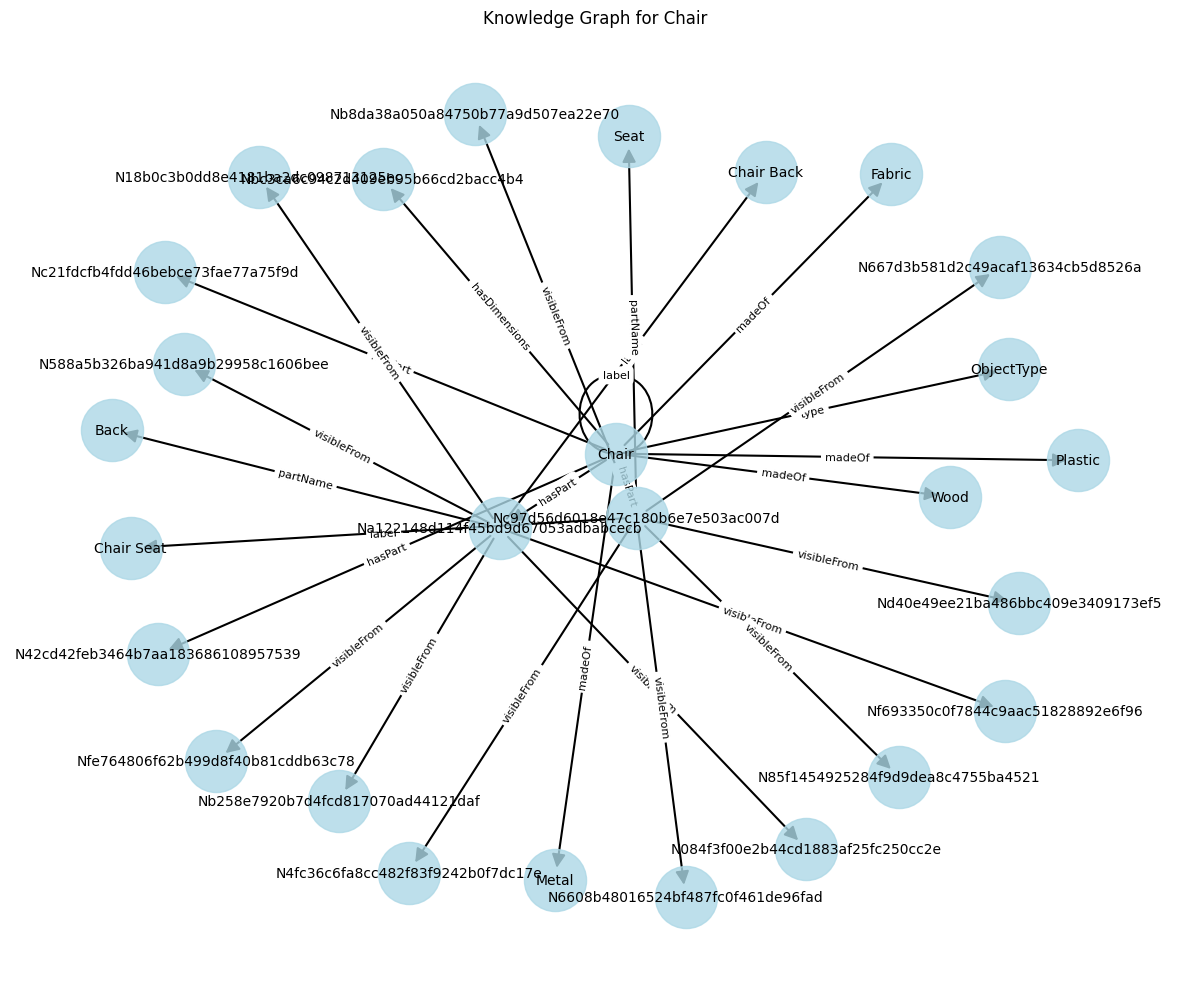

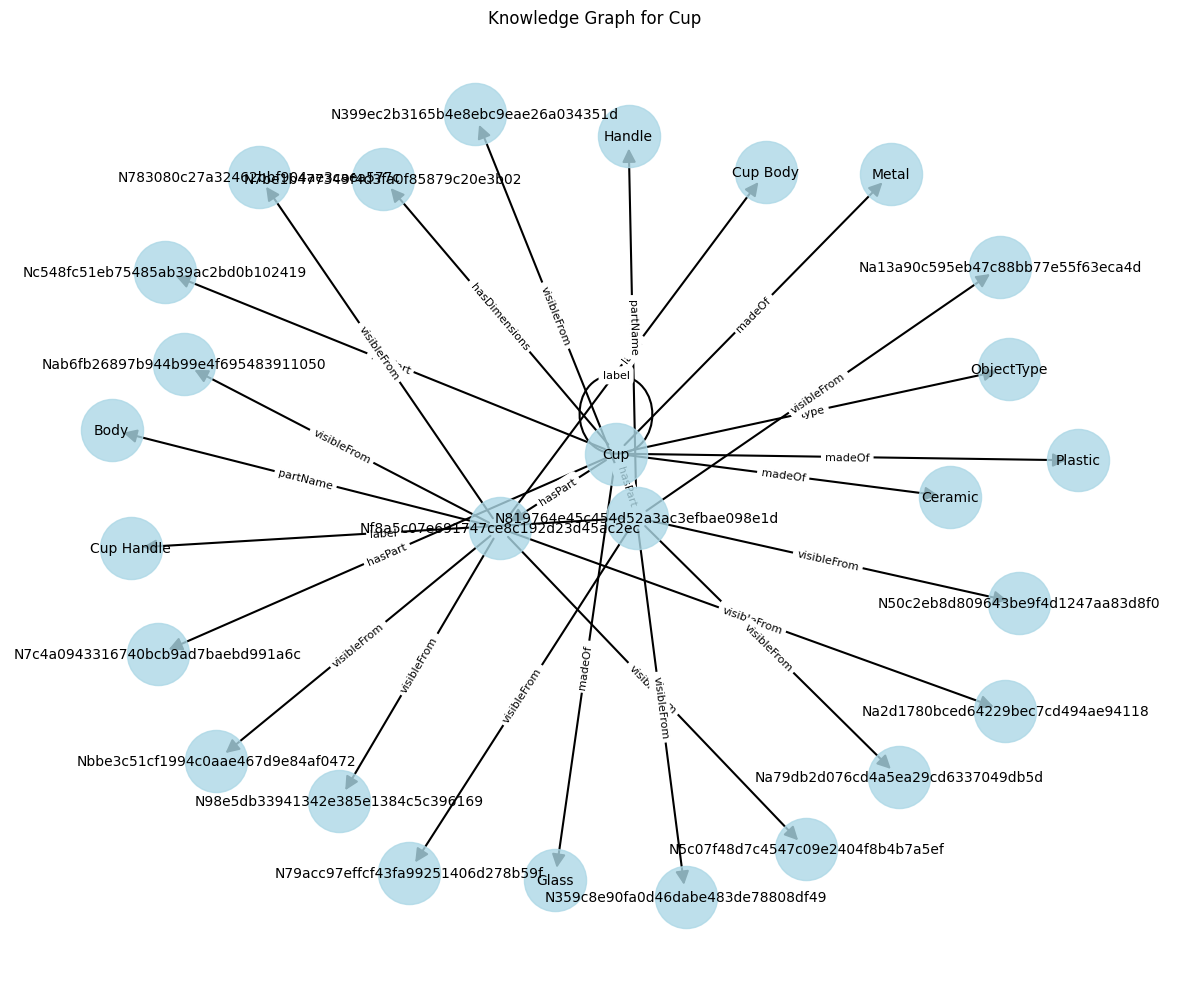

In [6]:
def visualize_knowledge_graph_for_object(g, object_name, limit=20):
    """Visualize a small portion of the knowledge graph for an object."""
    # Create a networkx graph
    G = nx.DiGraph()
    
    # Get all triples related to the object
    obj_uri = OBJ3D[object_name]
    
    # First level - direct properties of the object
    count = 0
    for s, p, o in g.triples((obj_uri, None, None)):
        # Add subject and object as nodes
        s_label = str(s).split('/')[-1]
        if isinstance(o, Literal):
            o_label = str(o)
        else:
            o_label = str(o).split('/')[-1] if '#' not in str(o) else str(o).split('#')[-1]
            if o_label.startswith('_'):  # Blank node
                o_label = f"blank_{count}"
                count += 1
        
        G.add_node(s_label)
        G.add_node(o_label)
        
        # Add predicate as edge label
        p_label = str(p).split('/')[-1] if '#' not in str(p) else str(p).split('#')[-1]
        G.add_edge(s_label, o_label, label=p_label)
        
        # Second level - for blank nodes or part nodes
        if isinstance(o, BNode) or str(p).endswith('hasPart'):
            for s2, p2, o2 in g.triples((o, None, None)):
                # Avoid going too deep
                if len(G.edges()) > limit:
                    break
                
                if isinstance(o2, Literal):
                    o2_label = str(o2)
                else:
                    o2_label = str(o2).split('/')[-1] if '#' not in str(o2) else str(o2).split('#')[-1]
                    if o2_label.startswith('_'):  # Blank node
                        o2_label = f"blank_{count}"
                        count += 1
                
                G.add_node(o2_label)
                
                p2_label = str(p2).split('/')[-1] if '#' not in str(p2) else str(p2).split('#')[-1]
                G.add_edge(o_label, o2_label, label=p2_label)
    
    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, arrowsize=20)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=10)
    
    # Draw edge labels
    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Knowledge Graph for {object_name}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the knowledge graph for a Chair
visualize_knowledge_graph_for_object(g, "Chair")

# Visualize the knowledge graph for a Cup
visualize_knowledge_graph_for_object(g, "Cup")

## Querying the Knowledge Graph

Now let's create functions to query our knowledge graph for information about 3D objects:


In [7]:
def get_object_parts(g, object_name):
    """Get all parts of an object."""
    parts = []
    obj_uri = OBJ3D[object_name]
    
    # Query for all parts of the object
    for s, p, o in g.triples((obj_uri, PROP["hasPart"], None)):
        for s2, p2, o2 in g.triples((o, PROP["partName"], None)):
            parts.append(str(o2))
    
    return parts

def get_object_dimensions(g, object_name):
    """Get dimensions of an object."""
    dimensions = {}
    obj_uri = OBJ3D[object_name]
    
    # Query for dimensions
    for s, p, o in g.triples((obj_uri, PROP["hasDimensions"], None)):
        for s2, p2, o2 in g.triples((o, None, None)):
            if str(p2).split('/')[-1] in ["height", "width", "depth"]:
                dimensions[str(p2).split('/')[-1]] = o2.value
    
    return dimensions

def get_part_visibility(g, object_name, part_name, viewpoint):
    """Get visibility of a part from a specific viewpoint."""
    obj_uri = OBJ3D[object_name]
    
    # Find the part node
    part_node = None
    for s, p, o in g.triples((obj_uri, PROP["hasPart"], None)):
        for s2, p2, o2 in g.triples((o, PROP["partName"], Literal(part_name))):
            part_node = o
    
    if part_node:
        # Query for visibility from the viewpoint
        for s, p, o in g.triples((part_node, PROP["visibleFrom"], None)):
            for s2, p2, o2 in g.triples((o, PROP["viewpoint"], Literal(viewpoint))):
                for s3, p3, o3 in g.triples((o, PROP["visibilityScore"], None)):
                    return o3.value
    
    return None

def get_visible_parts(g, object_name, viewpoint, threshold=0.5):
    """Get all parts visible from a specific viewpoint."""
    parts = get_object_parts(g, object_name)
    visible_parts = []
    
    for part in parts:
        visibility = get_part_visibility(g, object_name, part, viewpoint)
        if visibility is not None and visibility >= threshold:
            visible_parts.append((part, visibility))
    
    # Sort by visibility (most visible first)
    visible_parts.sort(key=lambda x: x[1], reverse=True)
    
    return visible_parts

# Test our query functions
object_name = "Chair"
print(f"Parts of a {object_name}:")
parts = get_object_parts(g, object_name)
print(parts)
print()

print(f"Dimensions of a {object_name}:")
dimensions = get_object_dimensions(g, object_name)
print(dimensions)
print()

viewpoint = "Front"
print(f"Visible parts of a {object_name} from {viewpoint} view:")
visible_parts = get_visible_parts(g, object_name, viewpoint)
for part, visibility in visible_parts:
    print(f"- {part}: {visibility:.2f}")
print()

# Compare visibility across different viewpoints
viewpoints = ["Front", "Side", "Back", "Top"]
part_name = "Seat"
print(f"Visibility of {object_name} {part_name} from different viewpoints:")
for vp in viewpoints:
    visibility = get_part_visibility(g, object_name, part_name, vp)
    print(f"- {vp}: {visibility:.2f}")

Parts of a Chair:
['Back', 'Seat', 'Legs', 'Armrests']

Dimensions of a Chair:
{'height': 80, 'width': 50, 'depth': 50}

Visible parts of a Chair from Front view:
- Back: 0.90
- Seat: 0.80
- Armrests: 0.80
- Legs: 0.70

Visibility of Chair Seat from different viewpoints:
- Front: 0.80
- Side: 0.60
- Back: 0.40
- Top: 1.00


## Visualizing Part Visibility Across Viewpoints

Let's create a visualization of part visibility across different viewpoints:


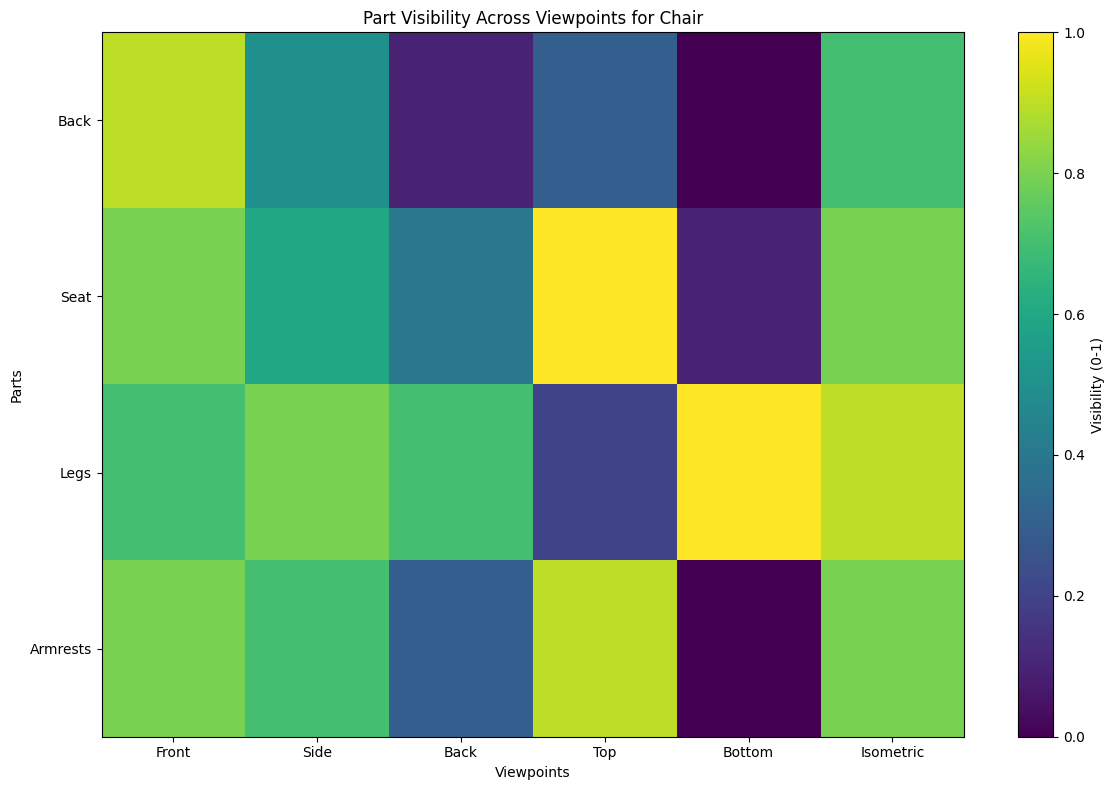

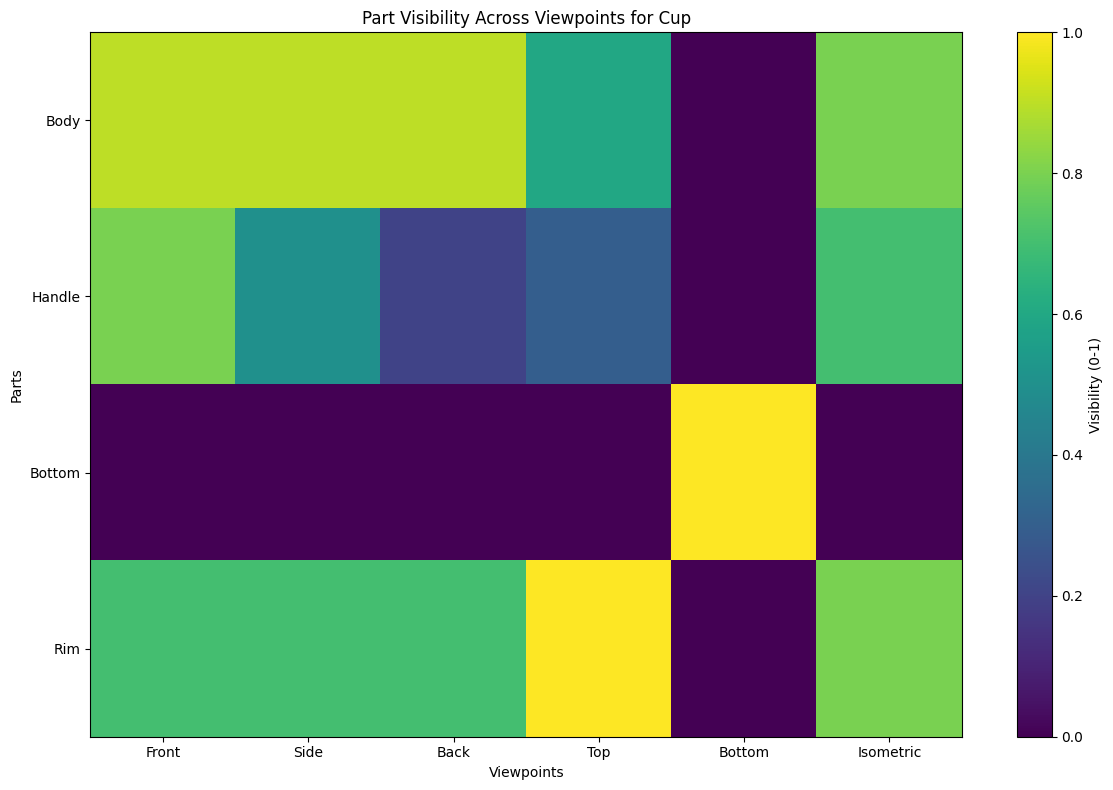

In [8]:
def visualize_part_visibility(g, object_name, viewpoints=None):
    """Visualize part visibility across different viewpoints."""
    if viewpoints is None:
        viewpoints = ["Front", "Side", "Back", "Top", "Bottom", "Isometric"]
    
    parts = get_object_parts(g, object_name)
    
    # Create a matrix of visibility values
    visibility_matrix = np.zeros((len(parts), len(viewpoints)))
    
    for i, part in enumerate(parts):
        for j, viewpoint in enumerate(viewpoints):
            visibility = get_part_visibility(g, object_name, part, viewpoint)
            if visibility is not None:
                visibility_matrix[i, j] = visibility
    
    # Create a heatmap
    plt.figure(figsize=(12, 8))
    plt.imshow(visibility_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    
    # Add labels
    plt.yticks(range(len(parts)), parts)
    plt.xticks(range(len(viewpoints)), viewpoints)
    plt.colorbar(label='Visibility (0-1)')
    
    plt.title(f'Part Visibility Across Viewpoints for {object_name}')
    plt.ylabel('Parts')
    plt.xlabel('Viewpoints')
    
    plt.tight_layout()
    plt.show()

# Visualize part visibility
visualize_part_visibility(g, "Chair")
visualize_part_visibility(g, "Cup")

## Connecting 3D Models to the Knowledge Graph

Let's now add links to 3D models and 2D renderings in our knowledge graph:


In [9]:
# Define sample URLs for 3D models and 2D renderings
model_urls = {
    "Chair": {
        "3d_model": "http://example.org/models/chair.obj",
        "renderings": {
            "Front": "http://example.org/images/chair_front.jpg",
            "Side": "http://example.org/images/chair_side.jpg",
            "Back": "http://example.org/images/chair_back.jpg",
            "Top": "http://example.org/images/chair_top.jpg"
        }
    },
    "Table": {
        "3d_model": "http://example.org/models/table.obj",
        "renderings": {
            "Front": "http://example.org/images/table_front.jpg",
            "Side": "http://example.org/images/table_side.jpg",
            "Top": "http://example.org/images/table_top.jpg"
        }
    },
    "Cup": {
        "3d_model": "http://example.org/models/cup.obj",
        "renderings": {
            "Front": "http://example.org/images/cup_front.jpg",
            "Side": "http://example.org/images/cup_side.jpg",
            "Top": "http://example.org/images/cup_top.jpg"
        }
    }
}

# Add model URLs to the graph
for obj, model_data in model_urls.items():
    # Add 3D model link
    g.add((OBJ3D[obj], PROP["has3DModel"], Literal(model_data["3d_model"], datatype=XSD.anyURI)))
    
    # Add rendering links
    for view, url in model_data["renderings"].items():
        rendering_node = BNode()
        g.add((OBJ3D[obj], PROP["hasRendering"], rendering_node))
        g.add((rendering_node, PROP["viewpoint"], Literal(view)))
        g.add((rendering_node, PROP["imageURL"], Literal(url, datatype=XSD.anyURI)))

# Query for model URLs
def get_model_url(g, object_name):
    """Get the 3D model URL for an object."""
    obj_uri = OBJ3D[object_name]
    
    for s, p, o in g.triples((obj_uri, PROP["has3DModel"], None)):
        return str(o)
    
    return None

def get_rendering_urls(g, object_name):
    """Get all rendering URLs for an object."""
    obj_uri = OBJ3D[object_name]
    renderings = {}
    
    for s, p, o in g.triples((obj_uri, PROP["hasRendering"], None)):
        viewpoint = None
        url = None
        
        for s2, p2, o2 in g.triples((o, PROP["viewpoint"], None)):
            viewpoint = str(o2)
        
        for s2, p2, o2 in g.triples((o, PROP["imageURL"], None)):
            url = str(o2)
        
        if viewpoint and url:
            renderings[viewpoint] = url
    
    return renderings

# Test URL queries
object_name = "Chair"
print(f"3D model URL for {object_name}:")
model_url = get_model_url(g, object_name)
print(model_url)
print()

print(f"Rendering URLs for {object_name}:")
rendering_urls = get_rendering_urls(g, object_name)
for view, url in rendering_urls.items():
    print(f"- {view}: {url}")

3D model URL for Chair:
http://example.org/models/chair.obj

Rendering URLs for Chair:
- Front: http://example.org/images/chair_front.jpg
- Side: http://example.org/images/chair_side.jpg
- Back: http://example.org/images/chair_back.jpg
- Top: http://example.org/images/chair_top.jpg


## Building a Simple Single-to-Multiview Reasoning Function

Now let's create a function that uses our knowledge graph to reason about how an object would look from different viewpoints given a single viewpoint:


In [10]:
def predict_multiview(g, object_name, known_viewpoint, target_viewpoints=None):
    """Predict how an object would look from different viewpoints based on a known viewpoint."""
    if target_viewpoints is None:
        target_viewpoints = ["Front", "Side", "Back", "Top"]
        if known_viewpoint in target_viewpoints:
            target_viewpoints.remove(known_viewpoint)
    
    # Get visible parts from the known viewpoint
    known_visible_parts = get_visible_parts(g, object_name, known_viewpoint)
    known_parts_dict = {part: visibility for part, visibility in known_visible_parts}
    
    predictions = {}
    for target_vp in target_viewpoints:
        # Get parts that should be visible from target viewpoint
        target_visible_parts = get_visible_parts(g, object_name, target_vp)
        target_parts_dict = {part: visibility for part, visibility in target_visible_parts}
        
        # Determine which parts will become visible or occluded
        newly_visible = []
        newly_occluded = []
        visibility_changes = {}
        
        all_parts = set(list(known_parts_dict.keys()) + list(target_parts_dict.keys()))
        
        for part in all_parts:
            known_vis = known_parts_dict.get(part, 0)
            target_vis = target_parts_dict.get(part, 0)
            
            if target_vis > 0.5 and known_vis <= 0.5:
                newly_visible.append(part)
            elif known_vis > 0.5 and target_vis <= 0.5:
                newly_occluded.append(part)
            
            visibility_changes[part] = target_vis - known_vis
        
        predictions[target_vp] = {
            "newly_visible": newly_visible,
            "newly_occluded": newly_occluded,
            "visibility_changes": visibility_changes
        }
    
    return predictions

# Test our multiview prediction function
object_name = "Chair"
known_viewpoint = "Front"
target_viewpoints = ["Side", "Back", "Top"]

predictions = predict_multiview(g, object_name, known_viewpoint, target_viewpoints)

print(f"Multiview predictions for {object_name} based on {known_viewpoint} view:")
for view, prediction in predictions.items():
    print(f"\nFrom {view} viewpoint:")
    print(f"Newly visible parts: {prediction['newly_visible']}")
    print(f"Newly occluded parts: {prediction['newly_occluded']}")
    print("Visibility changes:")
    for part, change in prediction['visibility_changes'].items():
        if abs(change) > 0.1:  # Only show significant changes
            print(f"  - {part}: {change:+.2f}")

Multiview predictions for Chair based on Front view:

From Side viewpoint:
Newly visible parts: []
Newly occluded parts: ['Back']
Visibility changes:
  - Back: -0.40
  - Legs: +0.10
  - Seat: -0.20
  - Armrests: -0.10

From Back viewpoint:
Newly visible parts: []
Newly occluded parts: ['Back', 'Seat', 'Armrests']
Visibility changes:
  - Back: -0.90
  - Seat: -0.80
  - Armrests: -0.80

From Top viewpoint:
Newly visible parts: []
Newly occluded parts: ['Back', 'Legs']
Visibility changes:
  - Back: -0.90
  - Legs: -0.70
  - Seat: +0.20


## Generating a Text Description for LLM Input

We can generate a textual description of the knowledge graph information for input to an LLM:


In [11]:
def generate_object_description_for_llm(g, object_name, viewpoint):
    """Generate a textual description of an object from a viewpoint for LLM input."""
    # Get basic information
    parts = get_object_parts(g, object_name)
    dimensions = get_object_dimensions(g, object_name)
    visible_parts = get_visible_parts(g, object_name, viewpoint)
    
    # Format dimensions
    dim_text = ", ".join([f"{dim}: {value} cm" for dim, value in dimensions.items()])
    
    # Format visible parts with visibility scores
    parts_text = ", ".join([f"{part} (visibility: {vis:.2f})" for part, vis in visible_parts])
    
    # Create description
    description = f"""Object: {object_name}
Viewpoint: {viewpoint}
Dimensions: {dim_text}
All parts: {', '.join(parts)}
Visible parts from this viewpoint: {parts_text}

The object is viewed from the {viewpoint.lower()} perspective. 
"""
    
    # Add information about parts not visible
    not_visible = [part for part in parts if part not in [p for p, v in visible_parts]]
    if not_visible:
        description += f"The following parts are not clearly visible from this angle: {', '.join(not_visible)}.\n"
    
    # Add predictions for other viewpoints
    other_viewpoints = ["Front", "Side", "Back", "Top"]
    if viewpoint in other_viewpoints:
        other_viewpoints.remove(viewpoint)
    
    predictions = predict_multiview(g, object_name, viewpoint, other_viewpoints)
    
    description += "\nPredictions for other viewpoints:\n"
    for view, prediction in predictions.items():
        description += f"\nFrom {view} viewpoint:\n"
        
        if prediction['newly_visible']:
            description += f"- Newly visible parts: {', '.join(prediction['newly_visible'])}\n"
        
        if prediction['newly_occluded']:
            description += f"- Newly occluded parts: {', '.join(prediction['newly_occluded'])}\n"
    
    return description

# Generate description for LLM
object_name = "Chair"
viewpoint = "Front"
description = generate_object_description_for_llm(g, object_name, viewpoint)

print("Description for LLM:")
print(description)

Description for LLM:
Object: Chair
Viewpoint: Front
Dimensions: height: 80 cm, width: 50 cm, depth: 50 cm
All parts: Back, Seat, Legs, Armrests
Visible parts from this viewpoint: Back (visibility: 0.90), Seat (visibility: 0.80), Armrests (visibility: 0.80), Legs (visibility: 0.70)

The object is viewed from the front perspective. 

Predictions for other viewpoints:

From Side viewpoint:
- Newly occluded parts: Back

From Back viewpoint:
- Newly occluded parts: Back, Seat, Armrests

From Top viewpoint:
- Newly occluded parts: Back, Legs



## Saving and Loading Knowledge Graphs

Knowledge graphs can be serialized and stored in various formats:


In [12]:
# Save the knowledge graph to a file in Turtle format
g.serialize(destination="3d_objects_knowledge_graph.ttl", format="turtle")

# Save in other formats
g.serialize(destination="3d_objects_knowledge_graph.xml", format="xml")
g.serialize(destination="3d_objects_knowledge_graph.json-ld", format="json-ld")

# To load a knowledge graph from a file
def load_knowledge_graph(file_path, format="turtle"):
    """Load a knowledge graph from a file."""
    new_graph = Graph()
    new_graph.parse(file_path, format=format)
    return new_graph

# Example load (commented out since we're working with an in-memory graph)
# loaded_g = load_knowledge_graph("3d_objects_knowledge_graph.ttl")

## Integration with LLM for Neurosymbolic Reasoning

Here's how our knowledge graph integrates with an LLM for neurosymbolic reasoning:


In [13]:
def neurosymbolic_reasoning(object_name, input_viewpoint, target_viewpoint):
    """
    Demonstrate the integration of knowledge graph with LLM for neurosymbolic reasoning.
    
    This is a simplified simulation for demonstration purposes.
    In a real system, you would use the actual LLM API.
    """
    # 1. Generate object description from the knowledge graph
    description = generate_object_description_for_llm(g, object_name, input_viewpoint)
    
    # 2. Create a prompt for the LLM
    prompt = f"""
You are a neurosymbolic AI system that can reason about 3D objects. 
I'll provide you with information about a {object_name} from the {input_viewpoint} view.
Based on this information, describe how the {object_name} would look from the {target_viewpoint} view.

Here is the information:
{description}

Provide a detailed description of the {object_name} from the {target_viewpoint} view, including:
1. Which parts will be visible and which will be occluded
2. How the overall shape will appear
3. Any significant changes in the appearance compared to the {input_viewpoint} view
"""
    
    # 3. In a real system, you would call the LLM API here
    # response = call_llm_api(prompt)
    
    # 4. For demonstration, we'll simulate an LLM response
    # This would be replaced by the actual LLM output
    simulated_response = f"""
Description of the {object_name} from the {target_viewpoint} view:

Based on the provided information, when viewing the {object_name} from the {target_viewpoint}, you would observe the following:

1. Visible and occluded parts:
"""
    
    # Get the predicted changes from the knowledge graph
    predictions = predict_multiview(g, object_name, input_viewpoint, [target_viewpoint])
    prediction = predictions[target_viewpoint]
    
    parts = get_object_parts(g, object_name)
    target_visible_parts = get_visible_parts(g, object_name, target_viewpoint)
    target_visible_names = [part for part, _ in target_visible_parts]
    
    # Add visible parts to the simulated response
    simulated_response += "   Visible parts:\n"
    for part, visibility in target_visible_parts:
        simulated_response += f"   - {part} (visibility: {visibility:.2f})\n"
    
    # Add occluded parts
    occluded_parts = [part for part in parts if part not in target_visible_names]
    simulated_response += "\n   Occluded parts:\n"
    for part in occluded_parts:
        simulated_response += f"   - {part}\n"
    
    # Add overall shape description
    dimensions = get_object_dimensions(g, object_name)
    simulated_response += f"""
2. Overall shape:
   The {object_name} will appear as a {dimensions['width']} cm wide by {dimensions['height']} cm tall object from the {target_viewpoint} view.
"""
    
    # Add significant changes
    simulated_response += f"""
3. Significant changes compared to the {input_viewpoint} view:
"""
    
    for part in prediction['newly_visible']:
        simulated_response += f"   - The {part} will become more visible\n"
    
    for part in prediction['newly_occluded']:
        simulated_response += f"   - The {part} will become less visible or occluded\n"
    
    return simulated_response

# Test our neurosymbolic reasoning function
object_name = "Chair"
input_viewpoint = "Front"
target_viewpoint = "Side"

response = neurosymbolic_reasoning(object_name, input_viewpoint, target_viewpoint)
print(response)


Description of the Chair from the Side view:

Based on the provided information, when viewing the Chair from the Side, you would observe the following:

1. Visible and occluded parts:
   Visible parts:
   - Legs (visibility: 0.80)
   - Armrests (visibility: 0.70)
   - Seat (visibility: 0.60)
   - Back (visibility: 0.50)

   Occluded parts:

2. Overall shape:
   The Chair will appear as a 50 cm wide by 80 cm tall object from the Side view.

3. Significant changes compared to the Front view:
   - The Back will become less visible or occluded



## Conclusion

In this tutorial, we've learned:

1. What a knowledge graph is and how to create one for 3D objects
2. How to store and query information about object parts, dimensions, and viewpoints
3. How to reason about object visibility from different viewpoints
4. How to predict multiview appearances from a single view
5. How to integrate knowledge graph information with LLMs for neurosymbolic reasoning

This knowledge graph component provides the symbolic reasoning capability for our neurosymbolic approach to single-to-multiview 3D understanding. When combined with the LLM and vision components from previous tutorials, it creates a powerful system that can leverage both neural and symbolic approaches to solve 3D perception challenges.